Importing packages and defining cleandf and printdf (data cleaning - removing ERROR value rows, NULL value rows,
correcting grammar)
Импортируем библиотеки, определяем функции printdf и cleandf. Первая - вспомогательная функция для печати таблицы. Вторая - для очищения данных - удаление рядов со значениями ERROR и NULL, а также исправление ошибок (например, Actve -> Active).

In [ ]:
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

DEBUG = False

def cleandf(df):
    # Check for NaN/null values
    print("Null Values Before Cleaning:")
    print(df.isnull().sum())

    # Remove rows with NaN values
    df_cleaned = df.dropna()
    # Verify cleaning
    print("\nNull Values After Cleaning:")
    print(df_cleaned.isnull().sum())
    # =================================================================

    # Check for "ERROR" strings (non-numeric)
    print("\nRows with 'ERROR':")
    print(df[df.eq("ERROR").any(axis=1)])
    # Remove rows with "ERROR" (if any column contains it)
    df_cleaned = df_cleaned[~df_cleaned.eq("ERROR").any(axis=1)]

    print("\nDataFrame Shape Before ERROR removed:", df.shape)
    print("DataFrame Shape After ERROR removed:", df_cleaned.shape)
    # =================================================================

    # TYPOS
    # TODO: populate automatically, map most common val
    # to everything else

    # Create a mapping dictionary for corrections
    activity_corrections = {
        'Actve': 'Active', # Fixes typo
        'Highly Active': 'Highly_Active',  # Fixes space to underscore
        'Seddentary': 'Sedentary'  # Fixes double 'd'
    }

    # Apply the corrections to the Activity Level column
    df_cleaned['Activity Level'] = df_cleaned['Activity Level'].replace(activity_corrections)

    # Verify the changes
    print("Unique activity levels after cleaning:")
    print(df_cleaned['Activity Level'].unique())

    return df_cleaned

def printdf(df, force=False):
    if DEBUG or force:
        print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

 # Read the CSV file into a DataFrame
df = pd.read_csv('unclean_smartwatch_health_data.csv')  # or use StringIO if working with the text directly

printdf(df)

# removing NaN and ERROR rows
df = cleandf(df)
printdf(df)

Null Values Before Cleaning:
User ID                   201
Heart Rate (BPM)          400
Blood Oxygen Level (%)    300
Step Count                100
Sleep Duration (hours)    150
Activity Level            200
Stress Level              200
dtype: int64

Null Values After Cleaning:
User ID                   0
Heart Rate (BPM)          0
Blood Oxygen Level (%)    0
Step Count                0
Sleep Duration (hours)    0
Activity Level            0
Stress Level              0
dtype: int64

Rows with 'ERROR':
      User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
2      1860.0        247.803052               97.052954   2826.521994   
62     3068.0        115.078288               99.928041   1918.372142   
71     3041.0         64.799778               94.743857   4613.859266   
81     4499.0         41.709895               96.857347   1413.015778   
92     2021.0         70.243810               97.171134   2336.583406   
...       ...               ...                     

Removing duplicates
(убираем дупликаты)

In [4]:
# removing duplcates
df_no_dupl = df.drop_duplicates()
rows_before = len(df)
rows_after = len(df_no_dupl)
print("\nDuplicate Rows Removed:", rows_before - rows_after)

df = df_no_dupl
print("DataFrame Shape no duplicates:", df.shape)


Duplicate Rows Removed: 0
DataFrame Shape no duplicates: (8325, 7)


Checking types (numeric) and checking that values make sense
(проверка типов - числовое в числовое; проверка того, что у в таблице адекватные значения - нет отрицательного количества шагов, нет процентов выше 100 и т.д.)

In [ ]:
def check_types(df):
    # user id is an integer number not a fraction, so we convert
    df['User ID'] = df['User ID'].astype(int)
    df['Heart Rate (BPM)'] = pd.to_numeric(df['Heart Rate (BPM)'], errors='coerce')
    df['Step Count'] = pd.to_numeric(df['Step Count'], errors='coerce')
    df['Blood Oxygen Level (%)'] = pd.to_numeric(df['Blood Oxygen Level (%)'], errors='coerce')
    df['Sleep Duration (hours)'] = pd.to_numeric(df['Sleep Duration (hours)'], errors='coerce')
    df['Stress Level'] = pd.to_numeric(df['Stress Level'], errors='coerce')
    return df

def check_values(df):
    # HEART RATE
    too_low = df['Heart Rate (BPM)'] < 30
    too_high = df['Heart Rate (BPM)'] > 220
    invalid_heart_rate = too_low | too_high
    df = df[~invalid_heart_rate].copy()
    print(f"HEART RATE CHECK: rows removed: {invalid_heart_rate.sum()}")
    print("HEART RATE CHECK: shape:", df.shape)

    # BLOOD OXYGEN
    too_high = df['Blood Oxygen Level (%)'] > 100
    invalid_blood_oxygen = too_high
    df = df[~invalid_blood_oxygen].copy()
    print(f"BLOOD OXY CHECK: rows removed: {invalid_blood_oxygen.sum()}")
    print("BLOOD OXY CHECK: shape:", df.shape)

    # Negative step counts or sleep duration
    neg_steps = df['Step Count'] < 0
    neg_sleep = df['Sleep Duration (hours)'] < 0
    neg_vals = neg_steps | neg_sleep
    df = df[~neg_vals].copy()
    print(f"NEG VALS CHECK: rows removed: {neg_vals.sum()}")
    print("NEG VALS CHECK: shape:", df.shape)

    return df

# correcting types   
df = check_types(df)
# checking whether values make sense
df = check_values(df)

printdf(df, True)

HEART RATE CHECK: rows removed: 30
HEART RATE CHECK: shape: (8295, 7)
BLOOD OXY CHECK: rows removed: 0
BLOOD OXY CHECK: shape: (8295, 7)
NEG VALS CHECK: rows removed: 1
NEG VALS CHECK: shape: (8294, 7)
+---------+--------------------+------------------------+--------------------+------------------------+----------------+--------------+
| User ID |  Heart Rate (BPM)  | Blood Oxygen Level (%) |     Step Count     | Sleep Duration (hours) | Activity Level | Stress Level |
+---------+--------------------+------------------------+--------------------+------------------------+----------------+--------------+
|  4174   | 58.93977586209927  |   98.80965025422655    | 5450.390577516058  |   7.167235622316564    | Highly_Active  |     1.0      |
|  2294   |        40.0        |   96.89421334689396    | 13797.338044243395 |   7.367789630207228    |     Active     |     3.0      |
|  2095   | 96.28593768588723  |    94.2029097779196    | 10205.992256276271 |   8.378342673824589    | Highly_Active 

Analyze simple - mean values (средние значения), most common (самое распространенное), typical (типичное)

In [6]:
def analyze_simple(df):
    # 2. Calculate averages
    print("\nAverage Metrics:")
    print(f"Heart Rate: {df['Heart Rate (BPM)'].mean():.1f} BPM")
    print(f"Step Count: {df['Step Count'].mean():,.0f} steps")
    print(f"Blood Oxygen: {df['Blood Oxygen Level (%)'].mean():.1f}%")

    # 3. Most common sleep duration (mode)
    sleep_mode = df['Sleep Duration (hours)'].round(2).mode()[0]
    print(f"Most common sleep duration (rounded): {sleep_mode:.2f} hours")

    # 4. Typical stress level (median)
    stress_median = df['Stress Level'].median()
    print(f"Typical stress level: {stress_median} (median)")

analyze_simple(df)


Average Metrics:
Heart Rate: 75.3 BPM
Step Count: 7,001 steps
Blood Oxygen: 97.8%
Most common sleep duration (rounded): 5.83 hours
Typical stress level: 5.0 (median)


Analyze advanced 

1. How sleep duration changes with stress (как продолжительность сна зависит от стресса)
2. Do more active people do more steps (совершают ли активные люди больше шагов)
3. Heart rate vs stress relation (отношение между средцебиением и уровнем стресса)

In [7]:
def analyze_advanced(df):
    # 1. Does sleep duration change with stress level?
    sleep_stress = df.groupby('Stress Level')['Sleep Duration (hours)'].mean()
    print("\nAverage Sleep Duration by Stress Level:")
    print(sleep_stress)

    # 2. Do more active people have more steps?
    activity_steps = df.groupby('Activity Level')['Step Count'].mean().sort_values(ascending=False)
    print("\nAverage Steps by Activity Level:")
    print(activity_steps)

    # 3. Heart rate vs stress relationship
    hr_stress = df.groupby('Stress Level')['Heart Rate (BPM)'].mean()
    print("\nAverage Heart Rate by Stress Level:")
    print(hr_stress)

analyze_advanced(df)


Average Sleep Duration by Stress Level:
Stress Level
1.0     6.558796
2.0     6.521857
3.0     6.519740
4.0     6.423615
5.0     6.515654
6.0     6.498873
7.0     6.517072
8.0     6.447961
9.0     6.489265
10.0    6.548391
Name: Sleep Duration (hours), dtype: float64

Average Steps by Activity Level:
Activity Level
Active           7066.000617
Highly_Active    6977.764632
Sedentary        6958.806308
Name: Step Count, dtype: float64

Average Heart Rate by Stress Level:
Stress Level
1.0     75.854018
2.0     75.337277
3.0     74.319703
4.0     76.019202
5.0     74.904014
6.0     75.694550
7.0     75.673820
8.0     75.373552
9.0     74.640036
10.0    75.585969
Name: Heart Rate (BPM), dtype: float64


Finally we do vizualization using seaborn (simple graphs)
1. Barplot (activity level against stress level)
Столбчатая диаграмма (соответствие между уровнем активности и увронем стресса)

2. Histogram of heart rate (BPM)
Гистограмма частоты сердцебиения 

3. Scatter plot (sleep duration against step count)
Точечная диаграмма (соотетствие между продолжительностью сна и количеством шагов) 

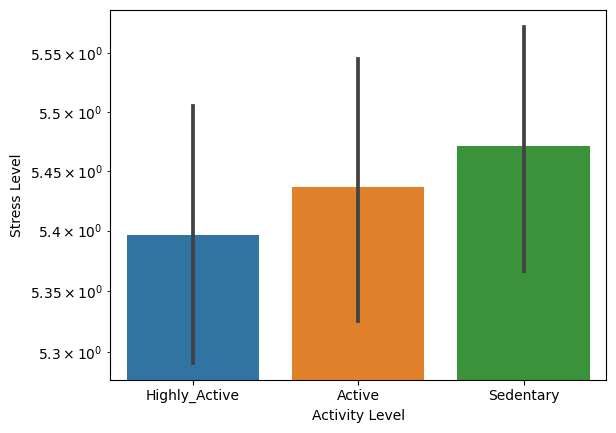

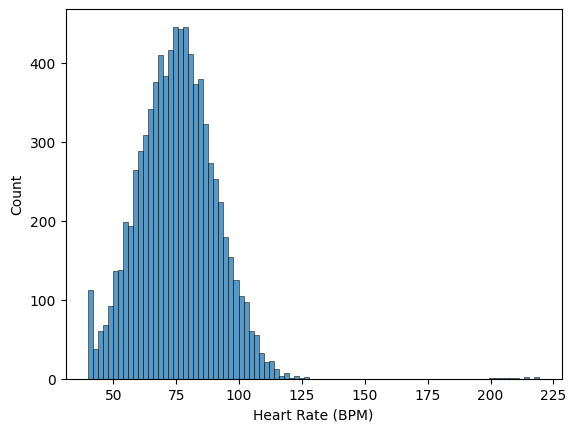

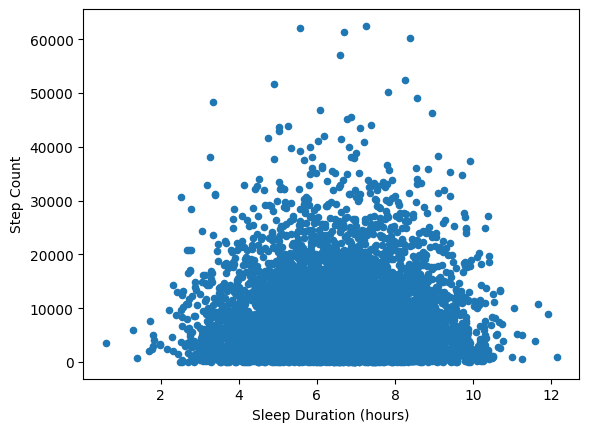

In [8]:
def visualize(df):
    user_id = "User ID"
    heart_rate = "Heart Rate (BPM)"
    blood_oxygen = "Blood Oxygen Level (%)"
    step_count = "Step Count"
    sleep_duration = "Sleep Duration (hours)"
    activity_level = "Activity Level"
    stress_level = "Stress Level"

    # BAR PLOT
    # decimal_places = 2
    # sns.barplot(data=df.assign(**{sleep_duration: df[sleep_duration].round(decimal_places)}), 
    #             x=sleep_duration, y=heart_rate)

    sns.barplot(data=df, x=activity_level, y=stress_level)
    plt.yscale('log')
    plt.show()
    # =================================================================

    # HISTOGRAM
    sns.histplot(df[heart_rate])
    plt.show()
    # =================================================================

    # SCATTER PLOT
    df.plot.scatter(x=sleep_duration, y=step_count)
    plt.show()

visualize(df)